# Speedrun Analysis
Analyzing how timed speedruns of the game Dark Souls 3 have advanced since its release on March 24, 2016.

This data (and related analysis) will be compared against the dates in which speed-enhancing explots or techniques were developed, to show their effects over time.

API documentation found at https://github.com/speedruncomorg/api

In [234]:
import requests as req
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import datetime as dt
import matplotlib.pyplot as plt
import json
import seaborn as sns

# ALL CURRENT RUNS

The structure of the dataframe holding run data:

**index** - index of run (index of dataframe, not actual column)

**players** - tuple containing status of player (user or guest) and 'None' if guest or their unique ID if user.

**date** - date of run, not of submission.

**times.primary_t** - primary submission time, used for leaderboard.

**times.ingame_t** - ingame time only, just in case. In the case of techniques involving quitting the game, restarting the game, etc.; ingame time is used to describe only the amount of time spent in-game.


In [235]:
# Initializing empty dataframe for harvest method
runsdf = pd.DataFrame()

In [236]:
## HARVEST ##
# This method relies on the structure of the speedrun.com API
# It is designed to get the json data from each runs page,
# normalize it into a pandas dataframe, and append it to the 
# above empty dataframe (or whichever dataframe is supplied).
def add_runs(url, df):
    r = req.get(url)
    data = r.json()
    # ignore_index true to get resultant dataframe without repeat indices.
    df = df.append(pd.json_normalize(data['data']), ignore_index = True)
    if len(data['pagination']['links']) == 2:
        return add_runs(data['pagination']['links'][1]['uri'], df)
    elif data['pagination']['links'][0].get('rel') == 'next':
        return add_runs(data['pagination']['links'][0]['uri'], df)
    else:
        return df

In [237]:
runsdf = add_runs('https://www.speedrun.com/api/v1/runs?game=k6qg0xdg&max=200', runsdf)

In [238]:
with pd.option_context('display.max_rows',100, 'display.max_columns', 10):
    display(runsdf)
    #display(prunedlbdf)

,id,weblink,game,level,category,...,system.region,status.reason,splits.rel,splits.uri,videos
0,oy2ej8wy,https://www.speedrun.com/darksouls3/run/oy2ej8wy,k6qg0xdg,None,xk9lx0gk,...,None,NaN,NaN,NaN,NaN
1,2yw6gppm,https://www.speedrun.com/darksouls3/run/2yw6gppm,k6qg0xdg,None,xk9lx0gk,...,None,NaN,NaN,NaN,NaN
2,pm3x0v6m,https://www.speedrun.com/darksouls3/run/pm3x0v6m,k6qg0xdg,None,xk9lx0gk,...,None,no vid,NaN,NaN,NaN
3,0y6xg26y,https://www.speedrun.com/darksouls3/run/0y6xg26y,k6qg0xdg,None,n2y143z2,...,None,can you reupload to youtube? I don't have prem...,NaN,NaN,NaN
4,8yv0npoz,https://www.speedrun.com/darksouls3/run/8yv0npoz,k6qg0xdg,None,n2y143z2,...,None,duplicate,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1754,yv1dk16y,https://www.speedrun.com/darksouls3/run/yv1dk16y,k6qg0xdg,None,02qml3pd,...,None,NaN,NaN,NaN,NaN
1755,y4rdd2nz,https://www.speedrun.com/darksouls3/run/y4rdd2nz,k6qg0xdg,None,7kjz1ond,...,None,NaN,NaN,NaN,NaN
1756,z1rewg9m,https://www.speedrun.com/darksouls3/run/z1rewg9m,k6qg0xdg,None,7kjz1ond,...,None,NaN,NaN,NaN,NaN
1757,m7drp60m,https://www.speedrun.com/darksouls3/run/m7drp60m,k6qg0xdg,None,xk9lx0gk,...,None,https://youtu.be/Rzoui9rKVi8?t=300 Runners are...,NaN,NaN,NaN


In [239]:
# turning 'players' column into a tuple containing 
runsdf['players'] = runsdf['players'].apply(lambda x: (x[0].get('rel'), x[0].get('id')))

In [240]:
# marking data outside of our interest as 'NA' so it can be dropped when plotting.
runsdf.loc[(runsdf['times.primary_t'] < 1900), 'times.primary_t'] = pd.NA
runsdf.loc[(runsdf['times.primary_t'] > 12000), 'times.primary_t'] = pd.NA
# removing rejected runs as well
runsdf.loc[(runsdf['status.status'] == 'rejected'), 'status.status'] = pd.NA
# changing date column to real datetime
runsdf['date'] = pd.to_datetime(runsdf['date'], format='%Y-%m-%d')

In [241]:
# cutting down dataframe columns to described format, metadata largely discarded.
prunedrsdf = runsdf[['id', 'players','date','times.primary_t','times.ingame_t']]
prunedrsdf.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1692 entries, 0 to 1758
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               1692 non-null   object        
 1   players          1692 non-null   object        
 2   date             1692 non-null   datetime64[ns]
 3   times.primary_t  1692 non-null   object        
 4   times.ingame_t   1692 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 79.3+ KB


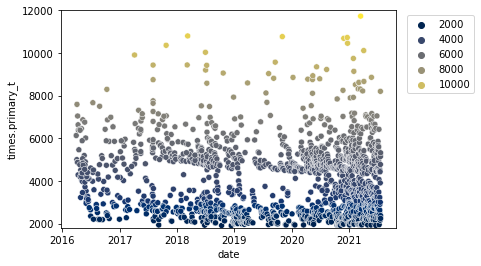

In [242]:
fig, ax = plt.subplots()

# using dropna() to prune the data for plotting.
sns.scatterplot(data=prunedrsdf.dropna(), x='date',y='times.primary_t', ax=ax, palette='cividis', hue='times.primary_t')
ax.set_ylim(bottom=1800, top=12000)
ax.legend(bbox_to_anchor=(1.25, 1), loc='upper right')
plt.show()

# CURRENT LEADERBOARD

In [243]:
dks3lb = req.get('https://www.speedrun.com/api/v1/leaderboards/k6qg0xdg/category/n2y143z2')

In [256]:
dks3lb = req.get('https://www.speedrun.com/api/v1/leaderboards/pd0wq31e/category/7kjrn323')

In [257]:
jsonlbs = dks3lb.json()

In [258]:
# cutting out the unnecessary accesses
leaderboard = jsonlbs['data']['runs']

In [259]:
# flattening json to dataframe. we will prune this in a moment for the
# relatively low number of columns we need.
leaderdf = pd.json_normalize(leaderboard)

In [260]:
# turning 'players' column into just the id of the player
leaderdf['run.players'] = leaderdf['run.players'].apply(lambda x: x[0].get('id'))

In [261]:
# changing date column to real datetime
leaderdf['run.date'] = pd.to_datetime(leaderdf['run.date'], format='%Y-%m-%d')

In [262]:
prunedlbdf = leaderdf[['place','run.id','run.date','run.times.primary_t', 'run.players']]

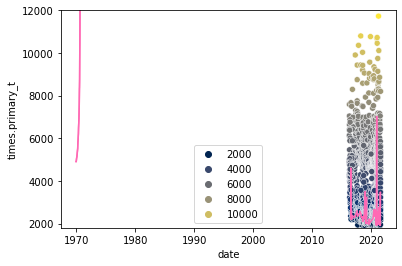

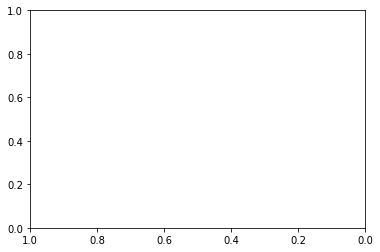

In [268]:
fig2, ax2 = plt.subplots()
sns.lineplot(data=prunedlbdf, x='place', y='run.times.primary_t' ,color='hotpink', ax=ax)
ax2.invert_xaxis()
fig